<a href="https://colab.research.google.com/github/lucas-albs/NN_same_person_recognition/blob/main/NN_same_person_recognition_with_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This artificial intelligence algorithm will be detecting whether two pictures contain the face of the same person**.

To do this, a basic neural network will be used. The model will be the MultiLayer Perceptron Classifier (MLPClassifier), from sklearn.

Additionally, the statistical method PCA will be used to reduce the number of dimensions in the image. Since MLPClassifiers are not ideal for image processing, the PCA will be required.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.datasets import fetch_lfw_pairs
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix 
from sklearn.neural_network import MLPClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 

The dataset being used is the Labeled Faces in the Wild, made available by sklearn. **There are pictures of 5749 people**.

After a few tries with a MLPClassifier without the PCA, it could be concluded that this model is not ideal for the problem at hand, since the accuracy barely got above 53%. This is why a pre-processing technique was adopted: a principal component analysis (PCA) was performed before feeding the images to the MLPClassifier.

**The PCA processes the images and returns an eigenface, which has only the most striking traits**. It reduces the dimensionality of the data, maintaining only the most important features.

In a simplified way, the PCA will calculate the maximum variance axis. For that, it will calculate the eigenvectors from the data matrix, and only the largest eigenvectors are kept. Then, the data is projected onto these eigenvectors, reducing dimensions while retaining as much information as possible. The result are the eigenfaces.

In [ ]:
lfw_pairs_train = fetch_lfw_pairs(subset='train', color=True)
#lfw_pairs_test = fetch_lfw_pairs(subset='test', color=True)
lfw_pairs_test = fetch_lfw_pairs(subset='10_folds',  color=True)

classes = lfw_pairs_test.target.shape[0]

xtrain = lfw_pairs_train.data;
ytrain = lfw_pairs_train.target;

xtest = lfw_pairs_test.data
ytest = lfw_pairs_test.target

n_components = 50
pca = PCA(n_components=n_components, whiten=True).fit(xtrain)
xtrain_pca = pca.transform(xtrain)
xtest_pca = pca.transform(xtest)

Below, a simple demonstration of what these eigenfaces look like.

The block of code below is not necessary for the project and is here for visualization only. It was an adapted code from [here](https://www.stats.ox.ac.uk/~sejdinov/teaching/dmml17/PCA_eigenfaces.html#:~:text=We%20will%20apply%20PCA%20to,faces%20collected%20from%20the%20web.).

original faces:


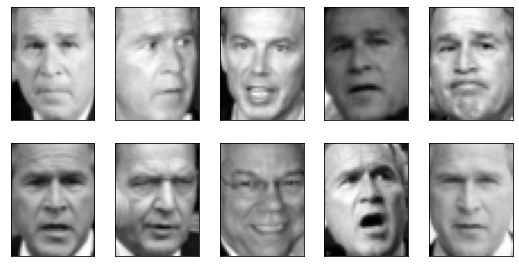

Eigenfaces (PCA):


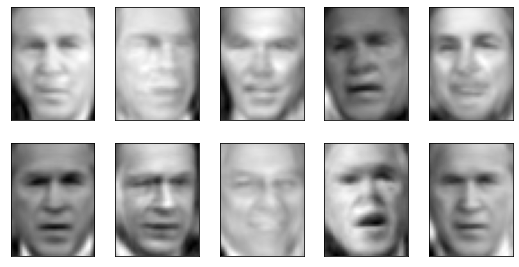

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

_, h, w = lfw_people.images.shape

def plot_faces(images, n_row=2, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 2.2 * n_row))
    plt.subplots_adjust(0.6, 0.5, 1.5, 1.5)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
    plt.tight_layout()
    plt.show()


X = lfw_people.data
y = lfw_people.target
# split into a training and testing set
_, X_test, _, _ = train_test_split(
    X, y, test_size=0.25, random_state=42)

X_test_pca = pca.transform(X_test)

print("original faces:")
plot_faces(X_test[:10])



print("Eigenfaces (PCA):")
X_test_rec = pca.inverse_transform(X_test_pca)
plot_faces(X_test_rec[:10])

Below, the neural network will finally be trained and validated. It will receive the PCA data.

A simple search algorithm with GridSearchCV is executed to find the best possible hyperparameters for the MLPClassifier.

Note: this is a very simple and inneficient grid search and it takes a long time to complete. There are also a few other problems with it. This is because finding the best neural network in an optimal amount of time was not the objective of this project. Currently, I am working on another project which has precisely this objective. It should be available on my GitHub in a few days.

In [ ]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))


#clf = MLPClassifier(hidden_layer_sizes=(1024), batch_size=512, learning_rate="adaptive", activation="relu", solver = 'adam', random_state=42, max_iter=300, early_stopping=True).fit(xtrain_pca, ytrain) 

clfModel = MLPClassifier(max_iter=300, early_stopping=True, random_state=42)

parameter_space = {
    'hidden_layer_sizes': list(powerset([256, 512, 1024, 2048])),
    'activation': ['tanh', 'relu'],
    'batch_size': [(64), (128), (256), (512), (1024)],
    'solver': ['adam'],
    #'alpha': [0.0001, 0.05],
    'learning_rate': ['adaptive'],
}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(clfModel, parameter_space, n_jobs=-1)
clf.fit(xtrain_pca, ytrain) 

print('Best parameters found:\n', clf.best_params_)

y_true, y_pred = ytest , clf.predict(xtest_pca)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

#print(clf.score(xtest_pca, ytest)) 

Best parameters found:
 {'activation': 'relu', 'batch_size': 128, 'hidden_layer_sizes': (2048,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Results on the test set:
              precision    recall  f1-score   support

           0       0.72      0.69      0.70      3000
           1       0.70      0.73      0.71      3000

    accuracy                           0.71      6000
   macro avg       0.71      0.71      0.71      6000
weighted avg       0.71      0.71      0.71      6000



The best hyperparameters found were: {'activation': 'relu', 'batch_size': 128, 'hidden_layer_sizes': (2048,), 'learning_rate': 'adaptive', 'solver': 'adam'}

**The final accuracy obtained was 71%**. Much better than the 53% obtained without PCA. Obviously, it is still far from good, because the MLPClassifier is not a good model for this task. To achieve better results, some other model more specialized for image processing would be needed, such as a Convolutional Neural Network. 

Still, this project concludes by showing how PCA can be applied to improve neural network performance by reducing the dimensionality of the data. 

**Below, some examples of the neural network in action**:

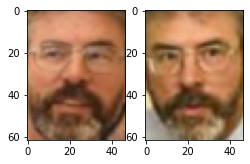

actual:     Same person
predicted:  Same person



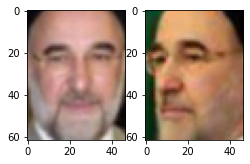

actual:     Same person
predicted:  Same person



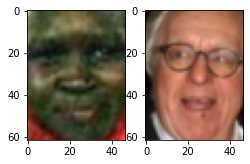

actual:     Different persons
predicted:  Different persons



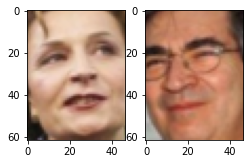

actual:     Different persons
predicted:  Different persons



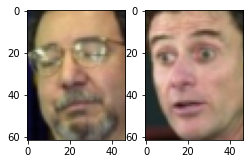

actual:     Different persons
predicted:  Same person



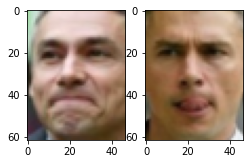

actual:     Same person
predicted:  Different persons



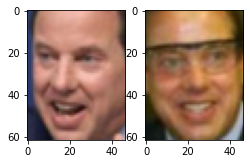

actual:     Same person
predicted:  Same person



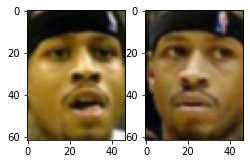

actual:     Same person
predicted:  Same person



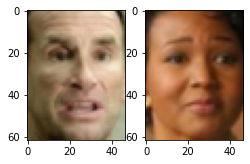

actual:     Different persons
predicted:  Different persons



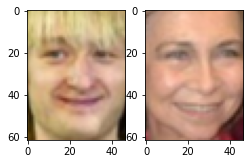

actual:     Different persons
predicted:  Same person



In [ ]:
import random

pairs = lfw_pairs_test.pairs
labels = lfw_pairs_test.target
ypred = clf.predict(xtest_pca)
target_names = lfw_pairs_test.target_names

actuals = []; predictions = []
for i in range(10):
   x = random.randint(0, pairs.shape[0])
   pair = pairs[x]
   img1 = pair[0]
   img2 = pair[1]
 
   fig = plt.figure()
 
   ax1 = fig.add_subplot(1,3,1)
   plt.imshow(img1/255)
 
   ax2 = fig.add_subplot(1,3,2)
   plt.imshow(img2/255)
 
 
   plt.show()
   print("actual:     " + target_names[labels[x]])
   print("predicted:  " + target_names[ypred[x]])

   print();